# Modern AI Pro: Reading Info from Tables
Modern documents have a lotof tables and the textual content is not easy to extract in conventional ways. We will use the state of the art transformers. Very useful for RPA and other applications

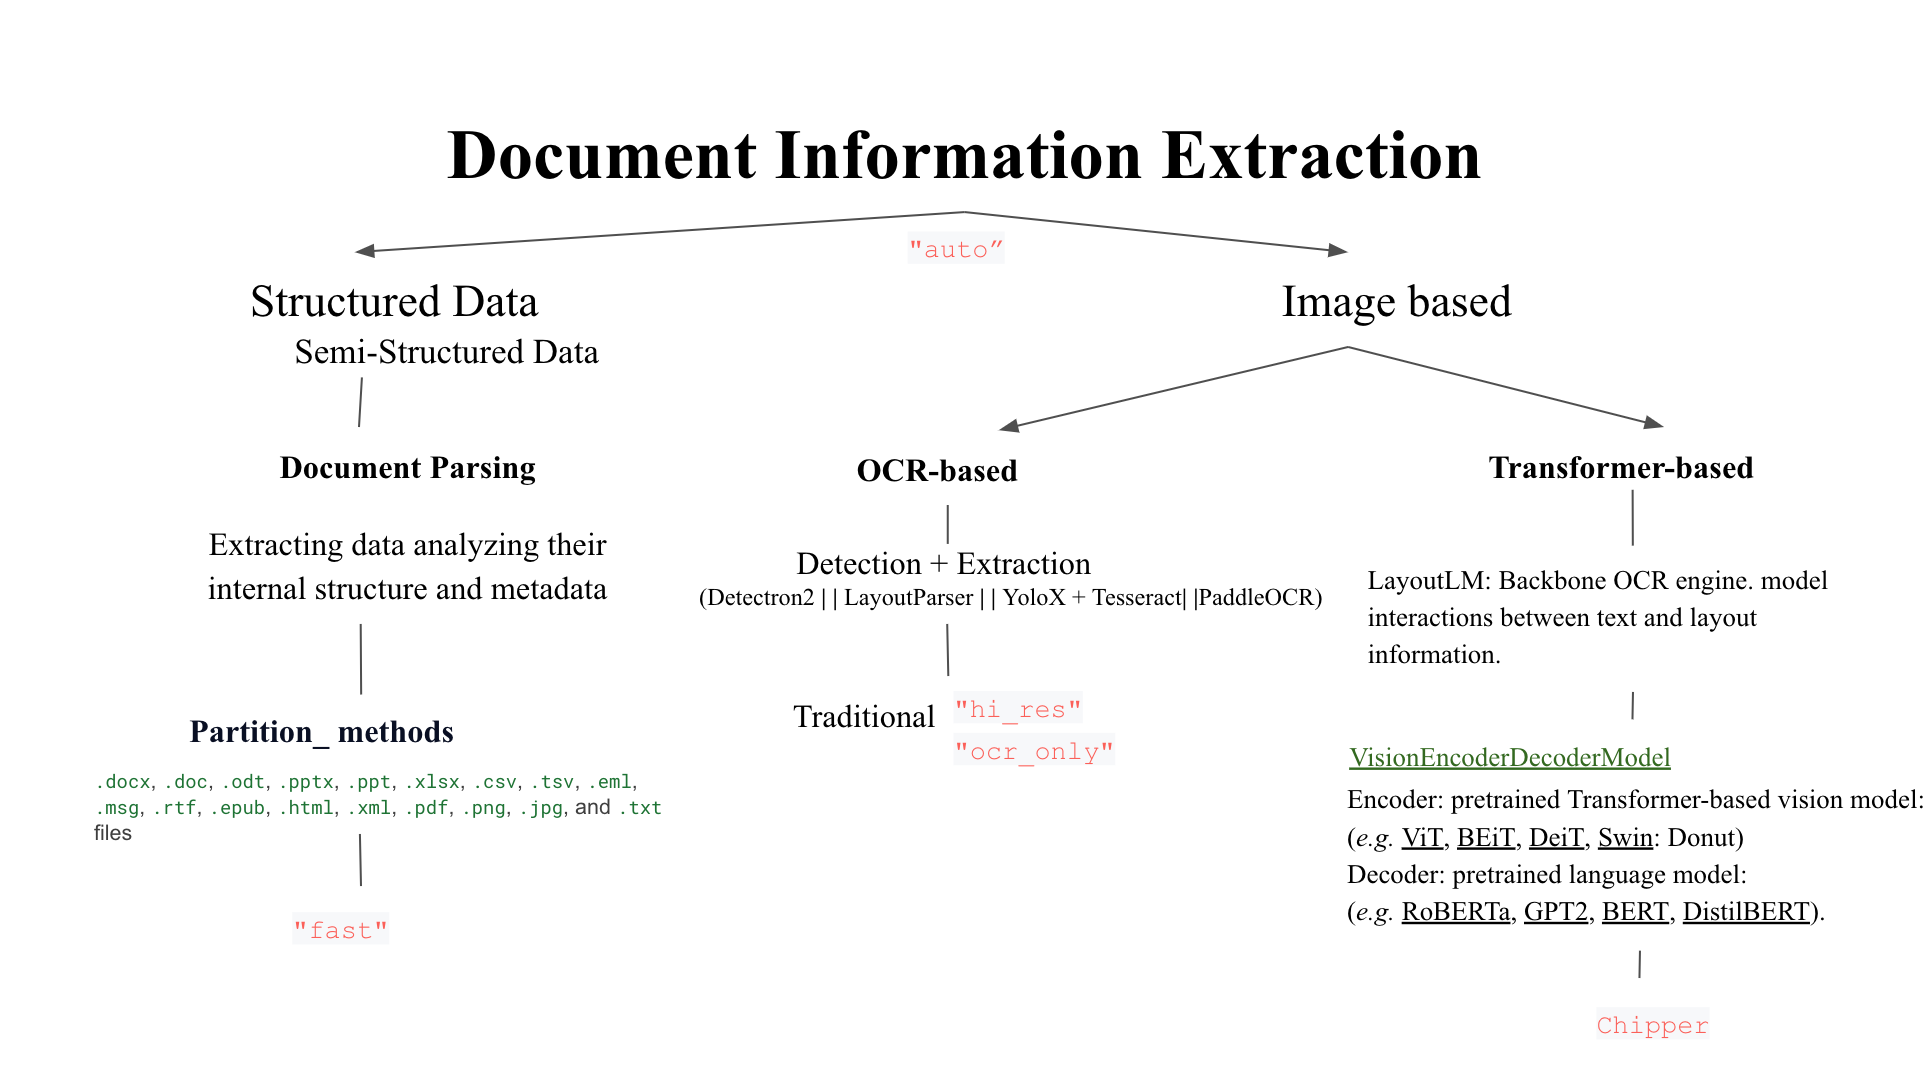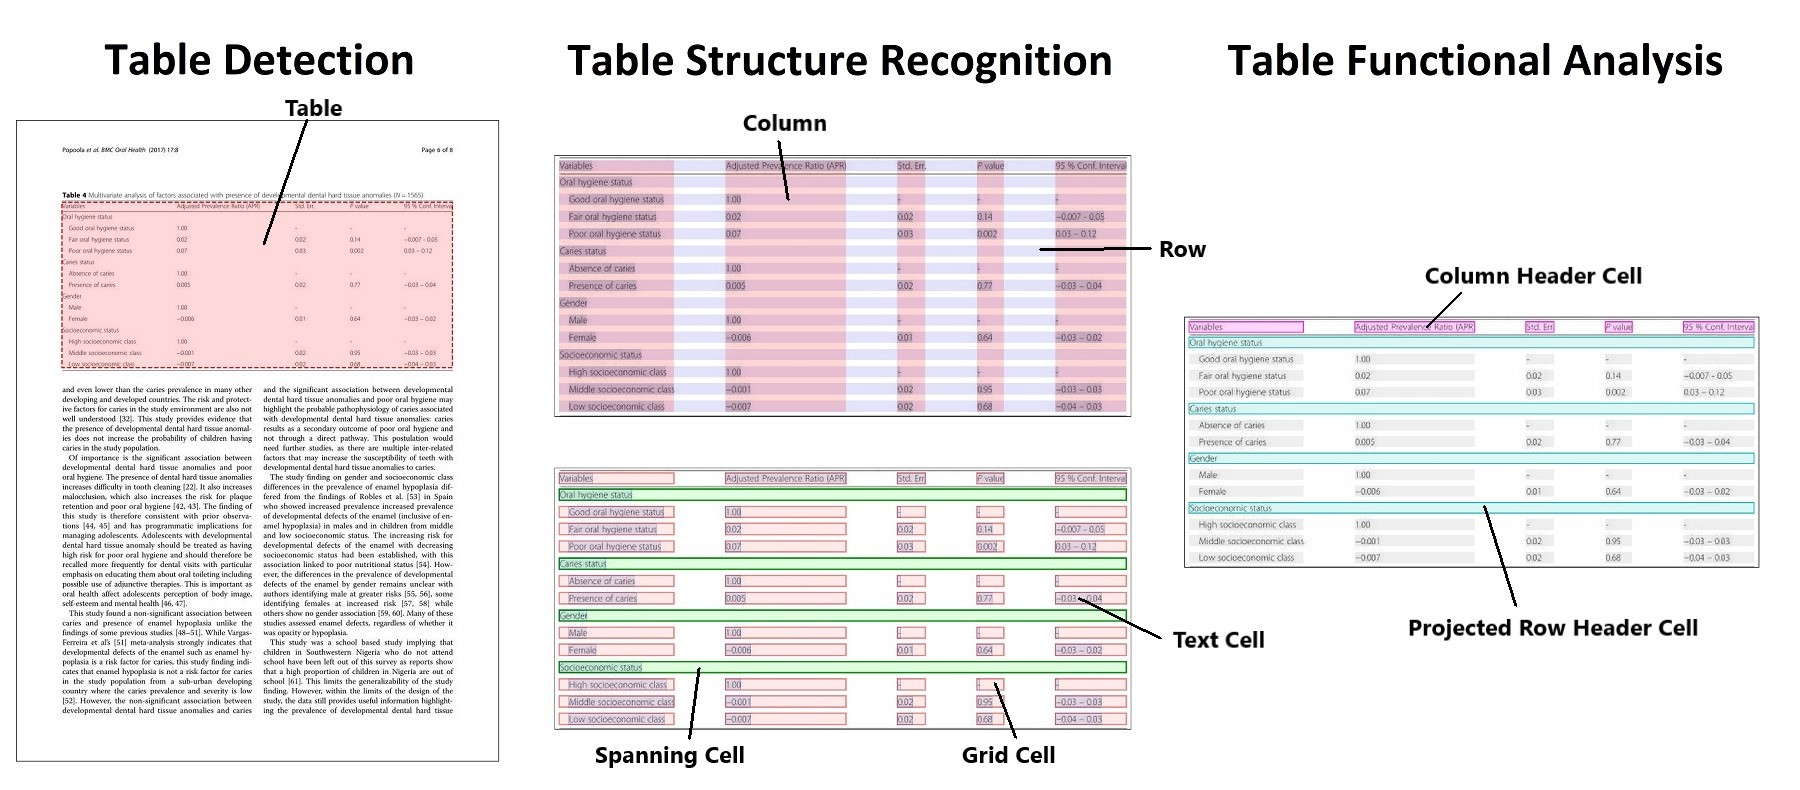

In [ ]:
# We will use a simple utility to make the text wrap properly when printing.
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Approach 1: LayoutLM

In [ ]:
!apt install -y tesseract-ocr
!apt-get install poppler-utils
!apt-get install libtesseract-dev
!pip install -q -U pytesseract unstructured[all-docs] pydantic lxml timm #PDF related

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


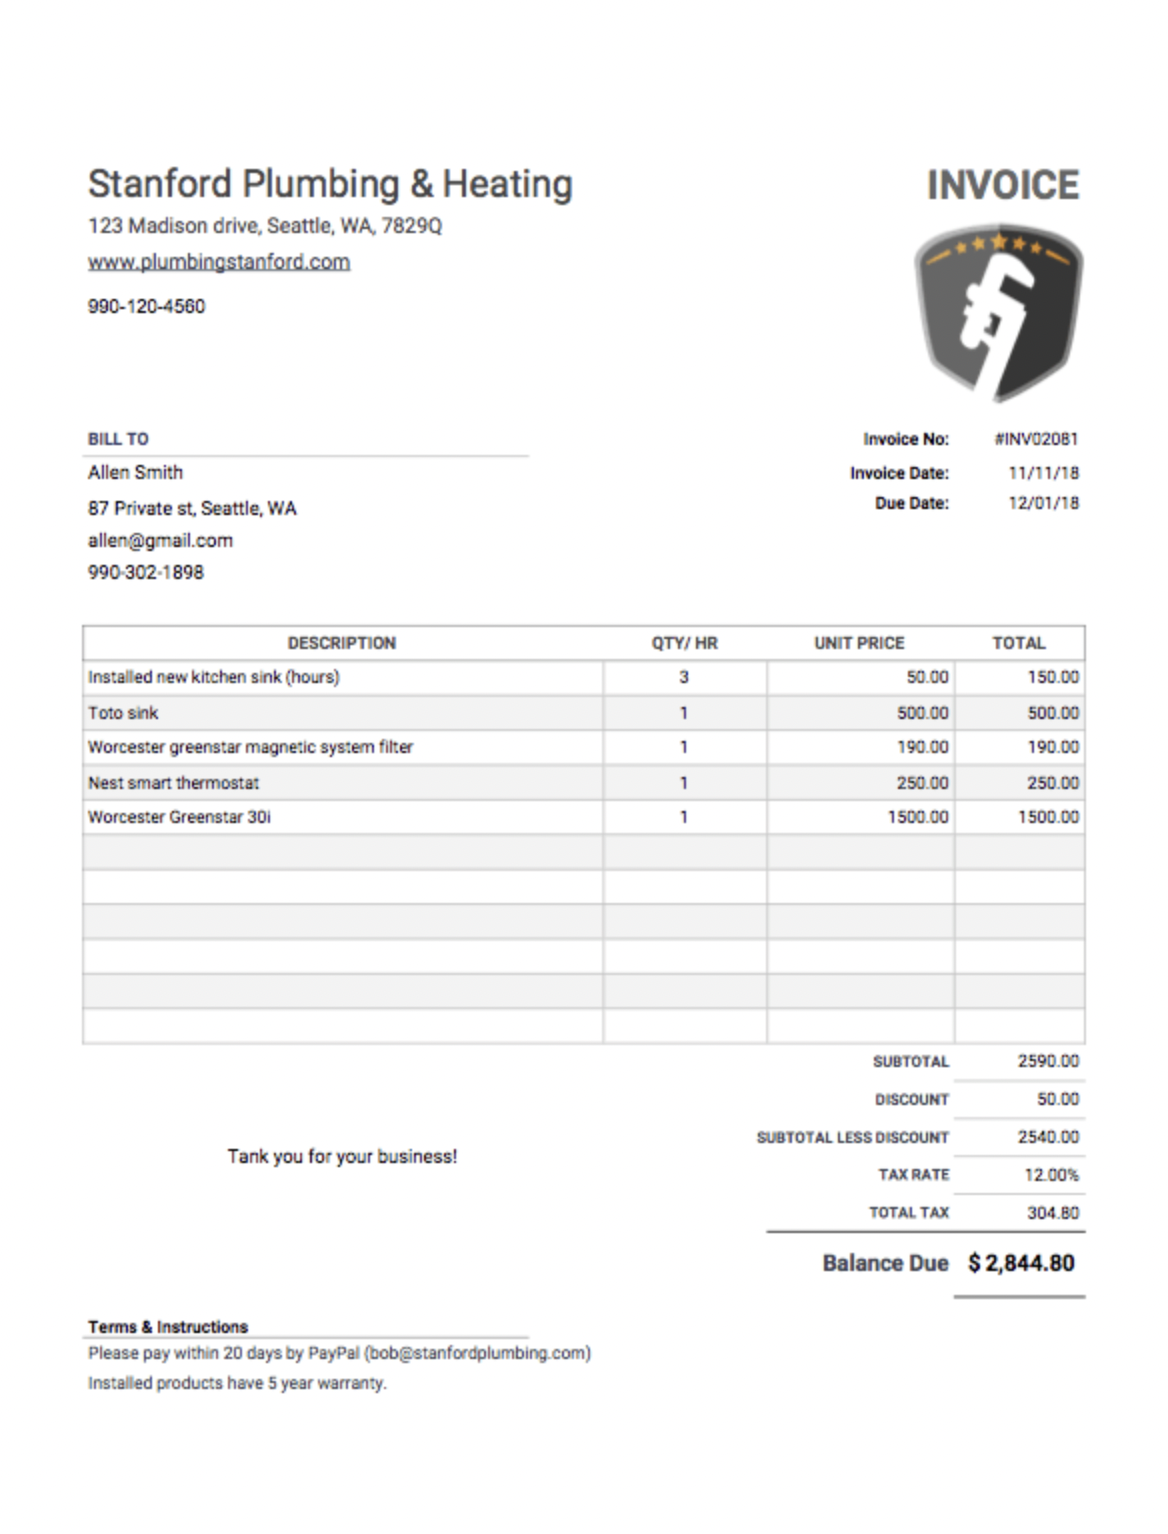

In [ ]:
from transformers import pipeline
layoutlm = pipeline(model="impira/layoutlm-document-qa")
image = "https://www.invoicesimple.com/wp-content/uploads/2018/06/Sample-Invoice-printable.png"

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/511M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
layoutlm(image=image,question="What is the invoice date?")

[{'score': 0.9987913966178894, 'answer': '1201/18', 'start': 24, 'end': 24}]

In [ ]:
layoutlm(image=image,question="What is the total amount due?")

[{'score': 0.9994825124740601, 'answer': '$2,844.80', 'start': 64, 'end': 64}]

In [ ]:
layoutlm(image=image,question="Who is this billed to")

[{'score': 0.9999097585678101,
  'answer': 'Allen Smith',
  'start': 14,
  'end': 15}]

## Approach 2: Donut DocVQA

In [ ]:
from PIL import Image
donutvqa = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")
#Ignore the warning 'Could not find image processor' class for now. Not FATAL.

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [ ]:
donutvqa(question="What is the invoice date?", image=image)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'answer': '11/11/18'}]

## Puttingthe models to use with Unstructured IO




In [ ]:
# Restart the runtime from the menu above, before you run this cell.
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename="arso.pdf", # https://drive.google.com/file/d/1I8Ga_BK23OA8EEv3DtAmo5zw_Quud0ew/view?usp=sharing
    infer_table_structure=True,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tables = [el for el in raw_pdf_elements if el.category == "Table"]
for table in tables:
    print("\n",table.text)


 Use case Score (0-5 with 5 being highest) Play a Game 4.30 Entertainment 3.80 Get Help 3.80 Call My Family 3.63 Bring water 3.43 Bring Food 3.34 Connect to my Doc 3.21 Bring Medicine 2.73 Mean 3.53

 Use case Play a Game Entertainment Get Help Call My Family Bring water Bring Food Connect to my Doc Bring Medicine Mean Males 4.41 3.94 4.00 3.35 3.41 3.25 3.12 2.88 3.55 Females 4.15 3.62 3.54 4.00 3.46 3.46 3.31 2.54 3.51

 Use case Play a Game Entertainment Get Help Call My Family Bring water Bring Food Connect to my Doc Bring Medicine Mean Seniors ≤ 80 years 4.43 4.14 4.14 3.57 3.50 3.62 3.31 3.29 3.75 Seniors > 80 years 4.19 3.50 3.50 3.69 3.38 3.12 3.12 2.25 3.34


In [ ]:
from IPython.display import HTML
html_table = tables[1].metadata.text_as_html
HTML(html_table)

Play a Game
Entertainment
Get Help
Call My Family
Bring water
Bring Food
Connect to my Doc
Bring Medicine
Mean


In [ ]:
tables = [el for el in raw_pdf_elements if el.category == "Table"]
for table in tables:
  print(table.category, "Page number: ",table.metadata.page_number, table.metadata.coordinates)

Table Page number:  3 CoordinatesMetadata(points=((931.4716796875, 148.41552734375), (931.4716796875, 400.03997802734375), (1488.76806640625, 400.03997802734375), (1488.76806640625, 148.41552734375)), system=<unstructured.documents.coordinates.PixelSpace object at 0x7b38f4539c00>)
Table Page number:  4 CoordinatesMetadata(points=((1009.6937866210938, 948.5054931640625), (1009.6937866210938, 1212.1168212890625), (1416.5552978515625, 1212.1168212890625), (1416.5552978515625, 948.5054931640625)), system=<unstructured.documents.coordinates.PixelSpace object at 0x7b38f4175180>)
Table Page number:  5 CoordinatesMetadata(points=((164.36387634277344, 143.2136688232422), (164.36387634277344, 399.553466796875), (819.0381469726562, 399.553466796875), (819.0381469726562, 143.2136688232422)), system=<unstructured.documents.coordinates.PixelSpace object at 0x7b38f4177460>)


In [ ]:
# We will now pick the first table
import pdf2image
points = tables[1].metadata.coordinates.points
page_num = tables[1].metadata.page_number  - 1
pages = pdf2image.convert_from_path('arso.pdf', dpi=200)
page_image = pages[page_num]
print(page_num)

3


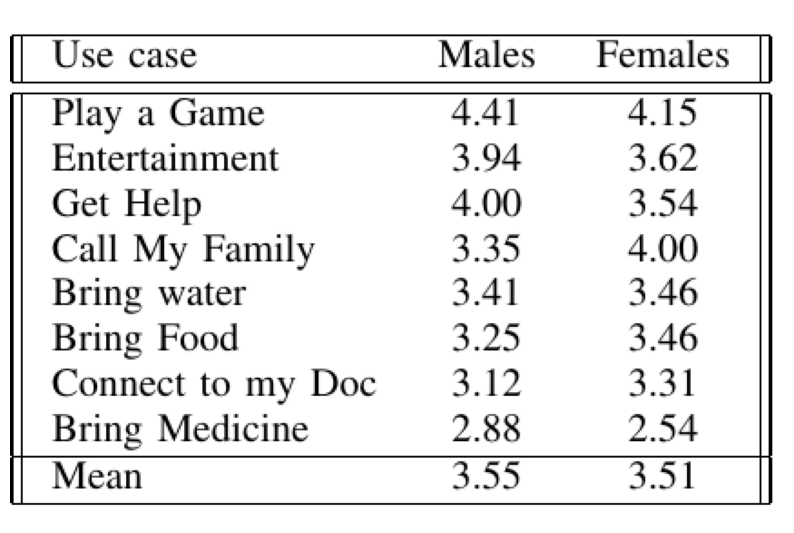

In [ ]:
import matplotlib.pyplot as plt

pad = 10
left, upper = points[0][0] - pad, points[0][1] - pad
right, lower = points[2][0] + pad, points[2][1] + pad
table_region = page_image.crop((left, upper, right, lower))

plt.figure(figsize=(10, 8))
plt.imshow(table_region)
plt.axis('off')  # Hide axes for better visualization
plt.show()


## Summarize the tables with LLM

In [ ]:
from google.colab import userdata

!pip install langchain git+https://gitlab.com/gauthammsam/mitrallm.git --quiet
from mitrallm import MitraLLM
llm = MitraLLM(
    token     = userdata.get("MITRA_TOKEN"),
    accessapi = userdata.get("MITRA_ENDPOINT")
)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.2/806.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 12.3 MB/s eta 0:00:00


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

summarize_chain = {"element": lambda x: x} | prompt | llm

In [ ]:
tables = [i.text for i in tables]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})
table_summaries

['The table presents scores for different use cases of an assistant, ranging from 0',
 'Summary: The table displays the mean ratings for different use cases by males and females',
 'Summary: The table shows the mean ratings given by seniors for different use cases of']

If you want to explore on this topic, beyond our bootcamp, you can read this reference article on table extraction apporaches: https://levelup.gitconnected.com/a-guide-to-processing-tables-in-rag-pipelines-with-llamaindex-and-unstructuredio-3500c8f917a7